In [1]:
!pip install kora -q
from kora import drive
drive.link_nbs()

     |████████████████████████████████| 57 kB 2.1 MB/s 
     |████████████████████████████████| 60 kB 3.8 MB/s 
Mounted at /content/drive


In [2]:
import utils
from google.colab.patches import cv2_imshow

importing Jupyter notebook from /nbs/utils.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
from keras import layers
from keras.callbacks import TensorBoard, LearningRateScheduler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#import efficientnet.keras as efn 
from utils import *
from keras.models import Sequential, Model,load_model
from keras import backend as K
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D, Dropout, GlobalAveragePooling2D, Lambda, ReLU
#from keras.layers import Input, Conv2D, ReLU, BatchNormalization,Add, AveragePooling2D, Flatten, Dense
from keras.initializers import glorot_uniform
import collections
import tensorflow
from tensorflow import Tensor


In [ ]:
""" Global variables """
IMG_SIZE = (224,224)
EPOCHS = 30
BATCH_SIZE = 32
NUM_CLASSES = 40 # 40 classes in the Stanford40 dataset

""" Load Stanford40 dataset """
#Load the dataset which has already been preprocessed, set needDirectories to False if SF_train, SF_test, and SF_validation dirs already exist
train_ds, test_ds, val_ds, train_labels, test_labels, validation_labels, class_names = utils.loadSF40(img_size =  IMG_SIZE, needDirectories=True)

#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices
#http://man.hubwiz.com/docset/TensorFlow_2.docset/Contents/Resources/Documents/tf/data/Dataset.html 


Streaming output truncated to the last 5000 lines.
cooking_936.jpg cooking
cooking_937.jpg cooking
cutting_trees_938.jpg cutting_trees
cutting_trees_939.jpg cutting_trees
cutting_trees_940.jpg cutting_trees
cutting_trees_941.jpg cutting_trees
cutting_trees_942.jpg cutting_trees
cutting_trees_943.jpg cutting_trees
cutting_trees_944.jpg cutting_trees
cutting_trees_945.jpg cutting_trees
cutting_trees_946.jpg cutting_trees
cutting_trees_947.jpg cutting_trees
cutting_trees_948.jpg cutting_trees
cutting_trees_949.jpg cutting_trees
cutting_trees_950.jpg cutting_trees
cutting_trees_951.jpg cutting_trees
cutting_trees_952.jpg cutting_trees
cutting_trees_953.jpg cutting_trees
cutting_trees_954.jpg cutting_trees
cutting_trees_955.jpg cutting_trees
cutting_trees_956.jpg cutting_trees
cutting_trees_957.jpg cutting_trees
cutting_trees_958.jpg cutting_trees
cutting_trees_959.jpg cutting_trees
cutting_trees_960.jpg cutting_trees
cutting_trees_961.jpg cutting_trees
cutting_trees_962.jpg cutting_trees
c

In [ ]:
""" One-hot encoding """

def onehot_encoding(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

#Apply one hot encoding to the different datasets
train_ds = train_ds.map(onehot_encoding, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(onehot_encoding, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(onehot_encoding)

print("Done one-hot encoding!")


Done one-hot encoding!


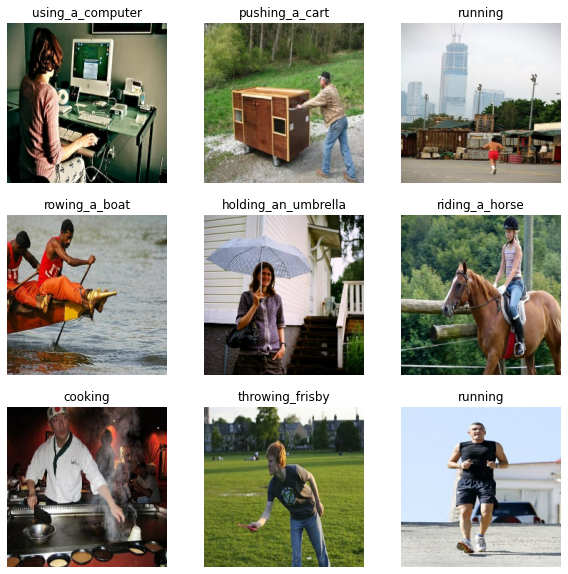

In [ ]:
#Visualize Data1
def format_label(label):
    index=[i for i, e in enumerate(label) if e == 1]
    return class_names[index[0]]
    #return string_label.split("-")[1]

plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title("{}".format(format_label(label[i])))
    plt.axis("off")

In [ ]:
def relu_bn(inputs: Tensor) -> Tensor:
    relu = tf.nn.relu(inputs)
    bn = BatchNormalization()(relu)
    return bn

In [ ]:
def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

In [ ]:
def create_res_net():   #Resnet20
    
    inputs = Input(shape=(224, 224, 3))
    num_filters = 16
    
    data_augmentation = Sequential([
        layers.Rescaling(scale=1./255),
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(mode="horizontal"),
        layers.RandomZoom(0.1)
    ],
    name="img_augmentation",)

    t = data_augmentation(inputs)

    t = BatchNormalization()(t)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [1, 1, 1, 1]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling2D(2)(t)
    t = Flatten()(t)
    outputs = Dense(40, activation='softmax')(t)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
model = create_res_net() 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img_augmentation (Sequential)  (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 3)  12         ['img_augmentation[0][0]']       
 alization)                                                                                       
                                                                                              

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("ResNet20_1", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1, save_format="tf")
early = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')

In [ ]:
model_history=model.fit(train_ds, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=val_ds, callbacks=[checkpoint,early])

Epoch 1/30
113/113 [==============================] - ETA: 0s - loss: 5.1107 - accuracy: 0.0614
Epoch 1: val_accuracy improved from -inf to 0.02750, saving model to ResNet20_1
INFO:tensorflow:Assets written to: ResNet20_1/assets
113/113 [==============================] - 40s 224ms/step - loss: 5.1107 - accuracy: 0.0614 - val_loss: 6.2464 - val_accuracy: 0.0275
Epoch 2/30
113/113 [==============================] - ETA: 0s - loss: 4.4884 - accuracy: 0.0803
Epoch 2: val_accuracy improved from 0.02750 to 0.04750, saving model to ResNet20_1
INFO:tensorflow:Assets written to: ResNet20_1/assets
113/113 [==============================] - 24s 210ms/step - loss: 4.4884 - accuracy: 0.0803 - val_loss: 5.4621 - val_accuracy: 0.0475
Epoch 3/30
113/113 [==============================] - ETA: 0s - loss: 3.9615 - accuracy: 0.1017
Epoch 3: val_accuracy improved from 0.04750 to 0.09500, saving model to ResNet20_1
INFO:tensorflow:Assets written to: ResNet20_1/assets
113/113 [==============================

In [8]:
#model.save('/content/drive/MyDrive/Colab Notebooks/ResNet20_1')
#model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ResNet20_1')
#model.save_weights('ResNet20_weights.h5')

In [ ]:
#Printing the val & training loss and accuracy for baseline model 
print(f"Baseline model training accuracy: {model_history.history['accuracy'][-1]} and validation accuracy: {model_history.history['val_accuracy'][-1]}")
print(f"Baseline model training loss: {model_history.history['loss'][-1]} and validation loss: {model_history.history['val_loss'][-1]}")

Baseline model training accuracy: 0.34166666865348816 and validation accuracy: 0.2175000011920929
Baseline model training loss: 2.3509178161621094 and validation loss: 3.0862679481506348


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


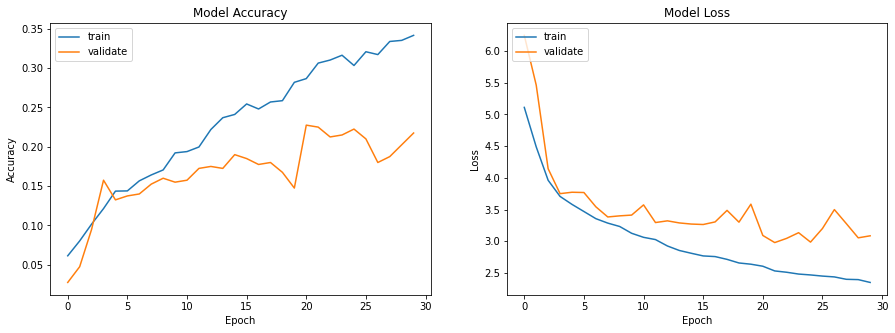

In [ ]:
#Plot loss and accuracy
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(model_history.history.keys())
plotmodelhistory(model_history)

In [ ]:
## Evaluation

ModelLoss, ModelAccuracy = model.evaluate(test_ds)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

173/173 [==============================] - 12s 66ms/step - loss: 3.0569 - accuracy: 0.2301
Model Loss is 3.056901454925537
Model Accuracy is 0.23011569678783417


In [ ]:
Y_pred = np.argmax(model.predict(test_ds),axis=1) 
print(Y_pred.shape)

(5532,)
